In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cpu')

In [7]:
zip_file_path = '/content/capstone1.zip'  # Gantilah dengan path file ZIP Anda
extracted_folder_path = '/content/extracted_capstone'  # Folder untuk mengekstrak file

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Tentukan transformasi untuk dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
train_dataset = ImageFolder(root='/content/extracted_capstone/Dataset_Capstone/DATASET/TRAIN', transform=transforms)
test_dataset = ImageFolder(root='/content/extracted_capstone/Dataset_Capstone/DATASET/TEST', transform=transforms)

In [10]:
len(train_dataset), len(test_dataset)

(22564, 2513)

In [11]:
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(18051, 4513)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(565, 142, 79)

In [13]:
def visualize(dataloader):
  images, labels = next(iter(dataloader))
  grid = make_grid(images, nrow=8).permute(1,2,0).numpy()

  plt.figure(figsize=(16,16))
  plt.imshow(grid)
  plt.show()

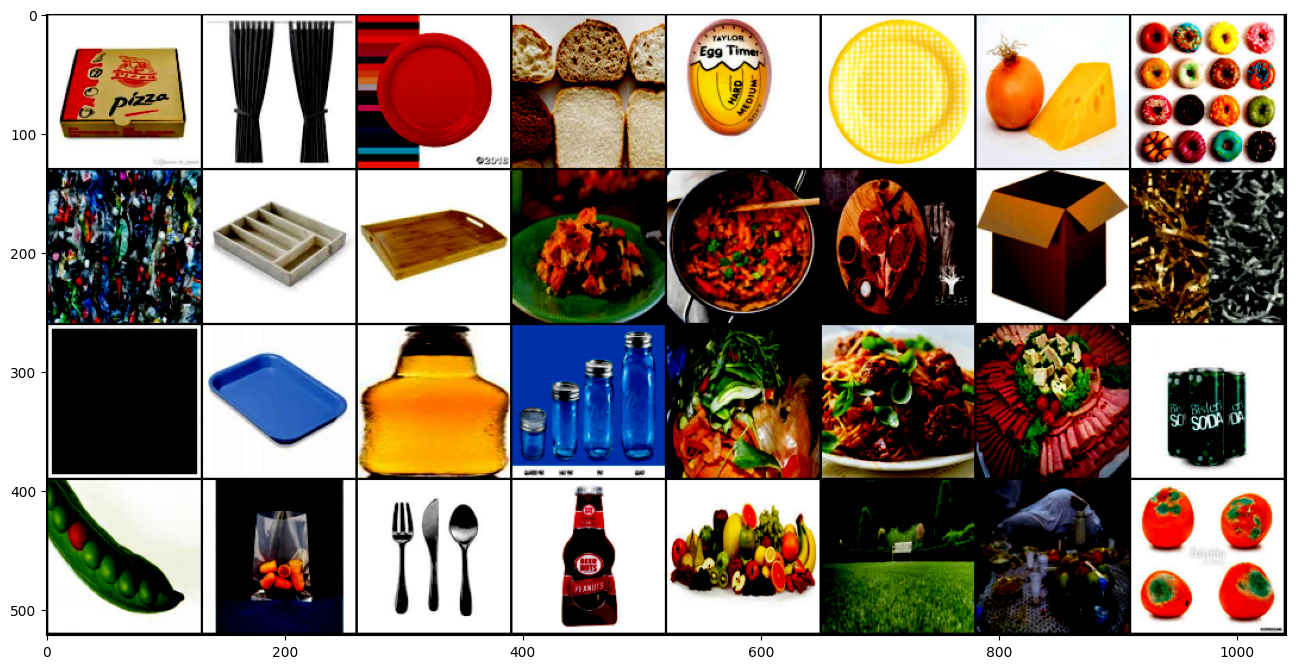

In [14]:
visualize(train_loader)

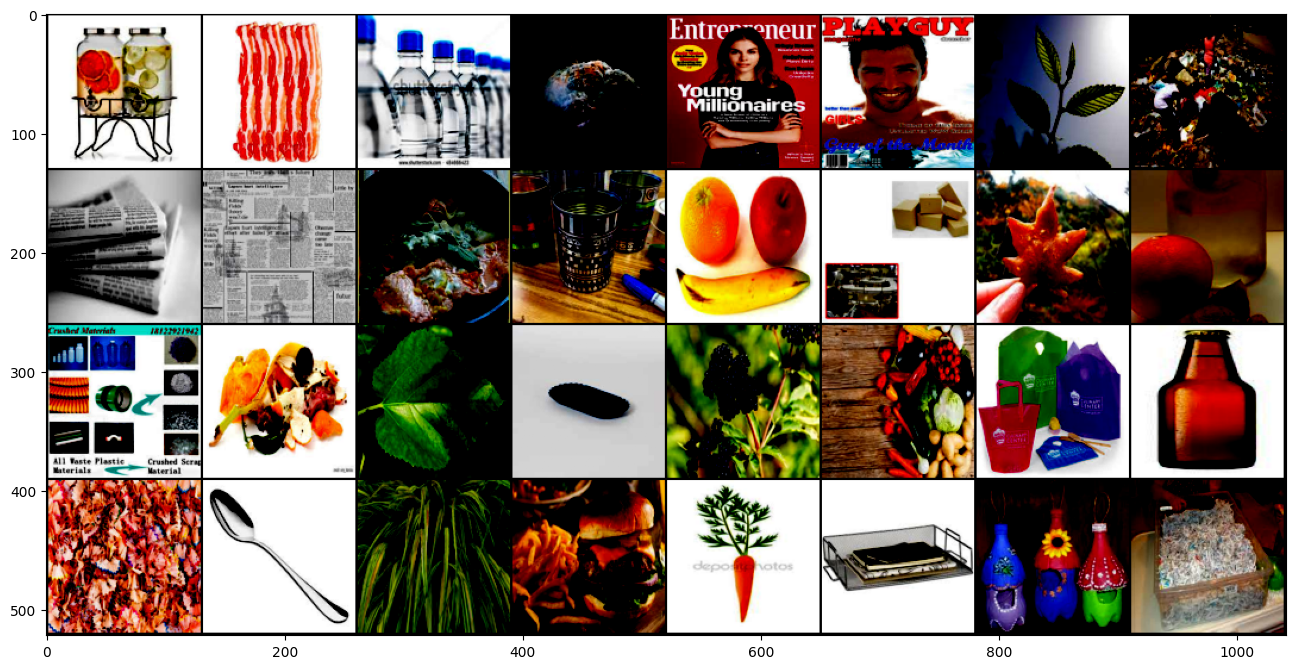

In [15]:
visualize(val_loader)

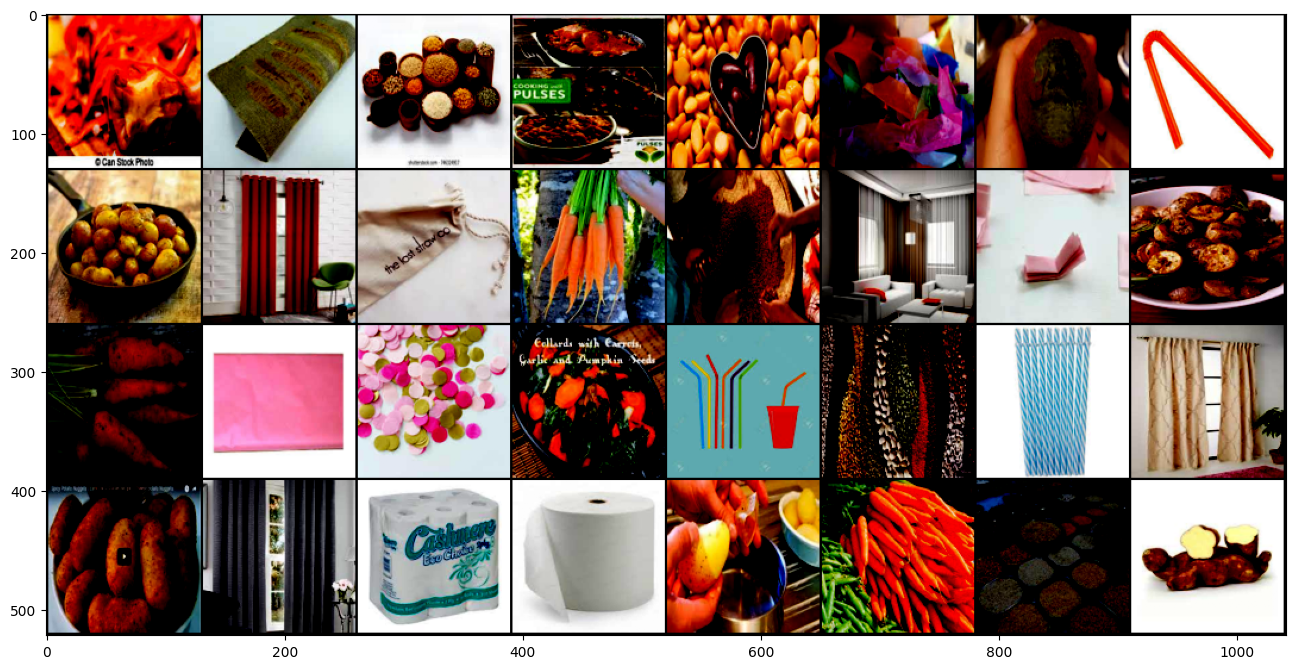

In [16]:
visualize(test_loader)

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Define the model layers
        self.model = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Flatten and fully connected layers
            nn.Flatten(),
            nn.Linear(16 * 29 * 29, 120),  # Adjust input size after convolution and pooling
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)  # Output layer, assuming 10 classes
        )

    def forward(self, x):
        return self.model(x)

In [18]:
model = LeNet()

model = model.to(device)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
              ReLU-2          [-1, 6, 124, 124]               0
         AvgPool2d-3            [-1, 6, 62, 62]               0
            Conv2d-4           [-1, 16, 58, 58]           2,416
              ReLU-5           [-1, 16, 58, 58]               0
         AvgPool2d-6           [-1, 16, 29, 29]               0
           Flatten-7                [-1, 13456]               0
            Linear-8                  [-1, 120]       1,614,840
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 1,628,726
Trainable params: 1,628,726
Non-trainable params: 0
---------------------------

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [20]:
epochs = 5

training_loss = []
validation_loss = []

for epoch in range(epochs):

    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        train_loss = loss_fn(outputs, labels)

        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item() * images.size(0)  # Accumulate loss

    epoch_train_loss /= len(train_loader.dataset)
    training_loss.append(epoch_train_loss)

    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for val_images, val_labels in val_loader:

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += val_loss.item() * val_images.size(0)

    epoch_val_loss /= len(val_loader.dataset)
    validation_loss.append(epoch_val_loss)

    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

KeyboardInterrupt: 

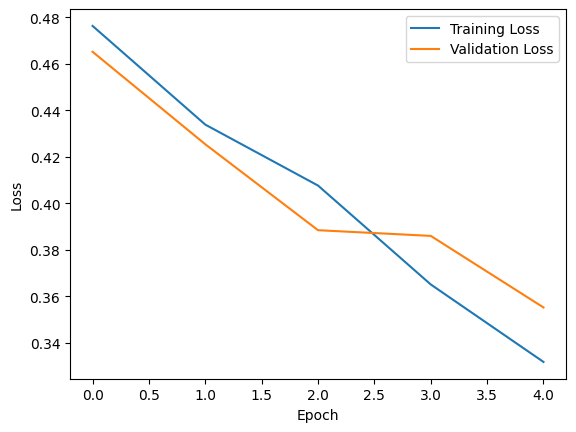

In [ ]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predicted_labels = []
actual_labels = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

Model Accuracy: 87.98%
Model Precision: 88.82%
Model Recall: 87.98%
Model F1 Score: 87.78%
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1401
           1       0.95      0.77      0.85      1112

    accuracy                           0.88      2513
   macro avg       0.89      0.87      0.88      2513
weighted avg       0.89      0.88      0.88      2513



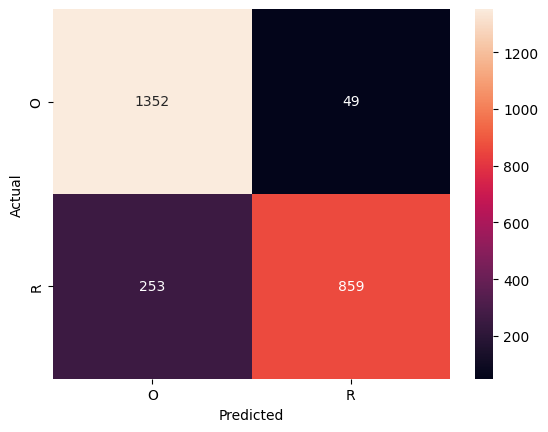

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


precision = precision_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Precision: {precision * 100:.2f}%")


recall = recall_score(actual_labels, predicted_labels, average='weighted')
print(f"Model Recall: {recall * 100:.2f}%")


f1 = f1_score(actual_labels, predicted_labels, average='weighted')
print(f"Model F1 Score: {f1 * 100:.2f}%")


print(classification_report(actual_labels, predicted_labels))


cm = confusion_matrix(actual_labels, predicted_labels)

class_names = test_loader.dataset.classes

sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')
print("Model Berhasil Di Simpan")

Model Berhasil Di Simpan
